# Error-state EKF



EKF is not a perfect method to estimate and predict the state, it will always make mistakes when predicting. The longer the number of sequential predictions without updates, the bigger the accumulated error. 

One interesting common property of the errors is that they have less complex behaviour than the state itself.

While the behaviour of the position is highly non-linear, the error (estimation - ground truth) behaves much closer to linear behaviour.

Therefore modelling the error of the state (i.e. error-state) is more likely that will be model correctly by a linear model. Therefore, we can avoid some noise coming from trying to model highly non-linear behaviour by modelling the error-state. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=180)

In [3]:
from utils import Quaternion

In [4]:
from utils import skew_operator

Start by visualizing ground truth position data

In [5]:
ground_truth_pos = np.genfromtxt('./data/ground_truth_pos.csv', delimiter=',',skip_header=1)
ground_truth_vel = np.genfromtxt('./data/ground_truth_vel.csv', delimiter=',',skip_header=1)
ground_truth_rot = np.genfromtxt('./data/ground_truth_rot.csv', delimiter=',',skip_header=1)

(-1.0, 5.0)

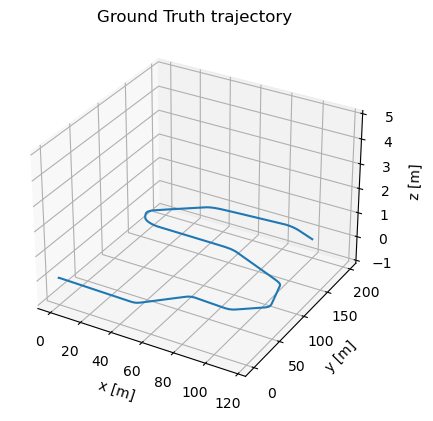

In [6]:
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(ground_truth_pos[:,0], ground_truth_pos[:,1], ground_truth_pos[:,2])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth trajectory')
ax.set_zlim(-1, 5)

Import GNSS data

In [7]:
gnss = np.genfromtxt("./data/gnss.csv", delimiter=',',skip_header=1)
gnss_ts = gnss[:,0]
gnss_data = gnss[:,1:]

Import IMU data

In [8]:
imu_f = np.genfromtxt("./data/imu_f.csv", delimiter=',',skip_header=1)
imu_f_ts = imu_f[:,0]
imu_f_data = imu_f[:,1:]


imu_w = np.genfromtxt("./data/imu_w.csv", delimiter=',',skip_header=1)
imu_w_ts = imu_w[:,0]
imu_w_data = imu_w[:,1:]

Import lidar data

In [9]:
lidar = np.genfromtxt("./data/lidar.csv", delimiter=',',skip_header=1)

In [10]:
lidar_ts = lidar[:,0]
lidar_data = lidar[:,1:]

LIDAR data used is actually just a set of positions estimated from a separate scan-matching system, so we can insert it into our solver as another position measurement, just as we do for GNSS. However, the LIDAR frame is not the same as the frame shared by the IMU and the GNSS. To remedy this, we transform the LIDAR data to the IMU frame using our known extrinsic calibration rotation matrix C_li and translation vector t_i_li.

In [11]:
# Calibration rotation matrix
C_li = np.array([
   [ 0.99376, -0.09722,  0.05466],
   [ 0.09971,  0.99401, -0.04475],
   [-0.04998,  0.04992,  0.9975 ]
])

# Translation vector

t_i_li = np.array([0.5, 0.1, 0.5])

Hence transforming LIDAR data from the LIDAR frame to the vehicle (IMU) frame

In [12]:
lidar_data = (C_li @ lidar_data.T).T + t_i_li

In [13]:
lidar_data

array([[-7.25929545e-01, -9.33445125e-02,  5.73395632e-02],
       [ 6.92859879e-01, -2.14174433e-01,  6.74380219e-01],
       [ 3.35226330e-01, -6.18522943e-01,  9.80182787e-01],
       ...,
       [ 1.82526392e+02,  7.83914550e+01, -3.55052408e-01],
       [ 1.83465455e+02,  7.88816509e+01, -3.19504638e-01],
       [ 1.85003213e+02,  7.78596469e+01, -2.80194945e-01]])

Set estimated sensor variances

In [14]:
var_imu_f = 0.10
var_imu_w = 0.25
var_gnss  = 0.01
var_lidar = 1.00

Define constants

In [15]:
g = np.array([0, 0, -9.81])  # gravity

l_jac = np.zeros([9, 6])

l_jac[3:, :] = np.eye(6)  # motion model noise jacobian

h_jac = np.zeros([3, 9])

h_jac[:, :3] = np.eye(3)  # measurement model jacobian

Set up initial values

In [16]:
p_est = np.zeros([imu_f_data.shape[0], 3])  # position estimates
v_est = np.zeros([imu_f_data.shape[0], 3])  # velocity estimates
q_est = np.zeros([imu_f_data.shape[0], 4])  # orientation estimates as quaternions
p_cov = np.zeros([imu_f_data.shape[0], 9, 9])  # covariance matrices at each timestep

In [17]:
imu_f_data

array([[-0.01996148,  0.03136036,  9.78135591],
       [-0.01986699,  0.03743271,  9.79679338],
       [ 0.01269854, -0.02131687,  9.81265361],
       ...,
       [-1.32458701,  0.35196761,  9.73522034],
       [-0.47210374, -0.42987602,  9.76335312],
       [-1.31729961,  0.29819817,  9.76891354]])

In [18]:
p_est[0] = ground_truth_pos[0]
v_est[0] = ground_truth_vel[0]
q_est[0] = Quaternion(euler=ground_truth_rot[0]).to_numpy()
p_cov[0] = np.zeros(9)  # covariance of estimate
gnss_i  = 0
lidar_i = 0

The following equations are used in the error state ekf

<img src="./images/es_ekf_equations.png" alt="Equations" />

Setup the solver

In [19]:
R_GNSS      =  np.identity(3) * var_gnss    # covariance matrix related to GNSS
R_Lidar     =  np.identity(3) * var_lidar   # covariance matrix related to Lidar
t_imu       =  imu_f_ts                      # timestanps of imu
t_gnss      =  gnss_ts                       # timestamps of gnss
t_lidar     =  lidar_ts                      # timestamps of lidar 
F_k         =  np.identity(9)
L_k         =  np.zeros([9, 6])
L_k[3:9, :] =  np.identity(6)
Q           =  np.identity(6)               # covariance matrix related to noise of IMU
Q[0:3, 0:3] =  Q[0:3, 0:3] * var_imu_f      # covariance matrix related to special force of IMU
Q[3:6, 3:6] =  Q[3:6, 3:6] * var_imu_w      # covariance matrix related to rotational speed of IMU


# THEORY

<img src="./images/img1.png" alt="Equations" />


<img src="./images/img2.png" alt="Equations" />

# Running through entire algorithm starting from index 1 (index 0 = initial from ground truth data)

In [20]:
k = 1 # Iter variable 

In [21]:
delta_t = imu_f_ts[k] - imu_f_ts[k - 1]
delta_t

0.004999999999999893

In [22]:
Q_k = Q * delta_t * delta_t
Q_k

array([[2.50e-06, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 2.50e-06, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 2.50e-06, 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 6.25e-06, 0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 6.25e-06, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 6.25e-06]])

In [23]:
C_ns = Quaternion(*q_est[k-1]).to_mat()
C_ns

array([[ 9.99999998e-01, -1.06248248e-06, -6.78301259e-05],
       [ 1.06526437e-06,  9.99999999e-01,  4.10126085e-05],
       [ 6.78300822e-05, -4.10126807e-05,  9.99999997e-01]])

Update state with IMU inputs

<img src="./images/img3.png" alt="Equations" />

In [24]:
p_est[k] = p_est[k-1] + delta_t * v_est[k-1] + delta_t ** 2 / 2 * (C_ns @ imu_f_data[k-1] + g)

v_est[k] = v_est[k-1] + delta_t * (C_ns @ imu_f_data[k-1] + g)

q_tmp = Quaternion( euler = (imu_w_data[k-1] * delta_t) ).quat_mult_right( q_est[k-1] )

q_est[k] = Quaternion(*q_tmp).normalize().to_numpy()

Linearize the motion model and compute Jacobians

<img src="./images/img4.png" alt="Equations" />

In [27]:
F_k[0:3, 3:6] = np.identity(3) * delta_t
F_k[3:6, 6:9] = - skew_operator( C_ns @ imu_f_data[k-1] ) * delta_t
F_k

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.00000000e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.00000000e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.00000000e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  4.89067662e-02, -1.58807495e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00, -4.89067662e-02, -0.00000000e+00, -1.03124901e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  1.58807495e-04,  1.03124901e-04, -0.00000000e+00],
       [ 0.00000000e+00,  0.

Progogate uncertainty

<img src="./images/img5.png" alt="Equations" />

In [29]:
p_cov[k] = F_k @ p_cov[k-1] @ F_k.T + L_k @ Q_k @ L_k.T
p_cov[k]

array([[0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 2.50e-06, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.50e-06, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.50e-06, 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 6.25e-06, 0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 6.25e-06, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 6.25e-06]])

Check availability of GNSS and LIDAR measurements

<img src="./images/img6.png" alt="Equations" />

<img src="./images/img7.png" alt="Equations" />

<img src="./images/img8.png" alt="Equations" />

In [52]:
def measurement_update(sensor_var, p_cov_check, y_k, p_check, v_check, q_check):

    # construct H_k = [I, 0, 0] (size = 3 x 9)
    H_k = np.zeros([3, 9])
    H_k[0:3, 0:3] = np.identity(3)

    # 3.1 Compute Kalman Gain
    # evaluate size chain: (9 x 9) x (9 x 3) x ( (3 x 9) x (9 x 9) x (9 x 3) + (3 x 3) )
    # K_k should have a size: (9 x 3)
    K_k = p_cov_check @ H_k.T @ np.linalg.inv(H_k @ p_cov_check @ H_k.T + sensor_var)

    # 3.2 Compute error state
    # evaluate size chain: (9 x 3) x ( (3 x 1) - (3 x 1) )
    # delta_x_k should have a size: (9 x 1)
    delta_x_k = K_k @ (y_k - p_check)
    
    # 3.3 Correct predicted state
    p_hat = p_check + delta_x_k[0:3]
    v_hat = v_check + delta_x_k[3:6]

    q_obj = Quaternion( euler = delta_x_k[6:9] ).quat_mult_left(q_check)
    q_hat = Quaternion(*q_obj).normalize().to_numpy()
    
    # 3.4 Compute corrected covariance
    # evaluate size chain: ( (9 x 9) - (9 x 3) x (3 x 9) ) x (9 x 9)
    p_cov_hat = ( np.identity(9) - K_k @ H_k ) @ p_cov_check

    return p_hat, v_hat, q_hat, p_cov_hat

Setting up solver loop for prediction step 

In [53]:
for k in range(1, imu_f_data.shape[0]):  # start at 1 b/c we have initial prediction from gt
    delta_t = imu_f_ts[k] - imu_f_ts[k - 1]

    Q_k = Q * delta_t * delta_t

    C_ns = Quaternion(*q_est[k-1]).to_mat()

    # 1. Update state with IMU inputs

    p_est[k] = p_est[k-1] + delta_t * v_est[k-1] + delta_t ** 2 / 2 * (C_ns @ imu_f_data[k-1] + g)

    v_est[k] = v_est[k-1] + delta_t * (C_ns @ imu_f_data[k-1] + g)

    q_tmp = Quaternion( euler = (imu_w_data[k-1] * delta_t) ).quat_mult_right( q_est[k-1] )

    q_est[k] = Quaternion(*q_tmp).normalize().to_numpy()


    # 1.1 Linearize the motion model and compute Jacobians

    F_k[0:3, 3:6] = np.identity(3) * delta_t
    F_k[3:6, 6:9] = - skew_operator( C_ns @ imu_f_data[k-1] ) * delta_t

    # 2. Propagate uncertainty

    p_cov[k] = F_k @ p_cov[k-1] @ F_k.T + L_k @ Q_k @ L_k.T

    # 3. Check availability of GNSS and LIDAR measurements
    ## at t_imu[k] timestamp GNSS has input
    if np.any( t_gnss == t_imu[k] ):
        # find time index @ iteration k
        t_k = np.where( t_gnss == t_imu[k] )[0][0]
        [ p_est[k], v_est[k], q_est[k], p_cov[k] ] = measurement_update( R_GNSS, p_cov[k], gnss_data[t_k], p_est[k], v_est[k], q_est[k] )


    ## at t_imu[k] timestamp Lidar has input
    if np.any( t_lidar == t_imu[k] ):
        # find time index @ iteration k
        t_k = np.where( t_lidar == t_imu[k] )[0][0]
        [ p_est[k], v_est[k], q_est[k], p_cov[k] ] = measurement_update( R_Lidar, p_cov[k], lidar_data[t_k], p_est[k], v_est[k], q_est[k] )
            

Visualize results

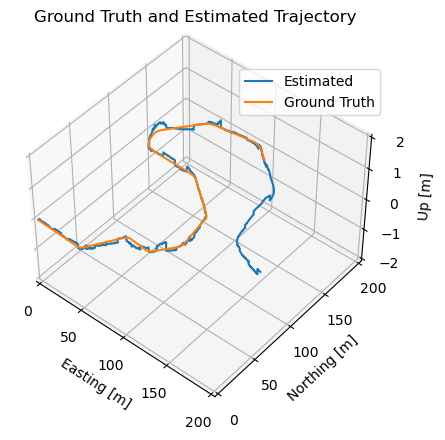

In [55]:
est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection='3d')
ax.plot(p_est[:,0], p_est[:,1], p_est[:,2], label='Estimated')
ax.plot(ground_truth_pos[:,0], ground_truth_pos[:,1], ground_truth_pos[:,2], label='Ground Truth')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_zlabel('Up [m]')
ax.set_title('Ground Truth and Estimated Trajectory')
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_zlim(-2, 2)
ax.set_xticks([0, 50, 100, 150, 200])
ax.set_yticks([0, 50, 100, 150, 200])
ax.set_zticks([-2, -1, 0, 1, 2])
ax.legend(loc=(0.62,0.77))
ax.view_init(elev=45, azim=-50)